In [1]:
#Import .h5 files from DLC, and relevant packages

import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

globbed_files = sorted(glob.glob("*.h5")) 

In [2]:
#Read data files into a list of data frames

dl = []
for h5 in globbed_files:
    frame = pd.read_hdf(h5)
    frame['filename'] = os.path.basename(h5)
    dl.append(frame)

In [3]:
#Rename files so they do not have excess than the core parts of the file name

def h5_process_regex(data):
    data['filename'] = data['filename'].str.replace('DLC_resnet50_WeightSupport3Points_updatedFeb24shuffle1_20000.h5', '')
    data['filename'] = data['filename'].str.replace('SIDEVIEW_', '')
    return data


In [4]:
for data in dl:
    data = h5_process_regex(data)
    
    #It is okay if an error/warning occurs, it does not affect the outcome of the function

In [5]:
#Drop levels so name of variables do not occur in multiple levels
def h5_process(data):
    data.columns = data.columns.droplevel()
    data.columns = data.columns.to_flat_index().str.join('_')
    data.columns.values[9] = "filename"
    return data

In [6]:
for data in dl:
    data = h5_process(data)
    

In [8]:
#Read dataframe containing info on how many steps were take in each video
df_steps = pd.read_csv("num_steps_new.csv")

In [10]:
#append info on number of steps in video to corresponding video in dl

for i in range(len(dl)):
    dl[i].loc[:,'num_steps'] = df_steps.loc[df_steps.filename.values == dl[i].filename.unique()[0]].Num_steps.values[0]  

In [12]:
#Create variable of binwidth based on number of frames / number of steps to get approximate step cycle length to find lowest front paw position and highest back position within step cycle
def h5_binwidth(data):
    data['binwidth'] = len(data.index)/data['num_steps']
    data['binwidth_int'] =data['binwidth'].astype(int)
    return data

In [13]:
for data in dl:
    data = h5_binwidth(data)

In [19]:
#Find lowest front paw position within each step cycle and top tailbase position in each step cycle.
def tbmin_fpmax(data):
    tailbase_y_l = []
    front_paw_y_l = []
    
    for i in range(0,len(data),data['binwidth_int'][0]):
        binwidth_int = data['binwidth_int'][0]
        min_tailbase = data['tailbase_y'][i:(i+binwidth_int)].min() # min means higher in visual frame
        max_front_paw = data['front_paw_y'][i:(i+binwidth_int)].max() # max means lower in visual frame
        
        for j in data['tailbase_y'][i:(i+binwidth_int)]:
            if j == min_tailbase:
                tailbase_y_l.append(min_tailbase)
            else:
                tailbase_y_l.append(np.nan)
                
        for j in data['front_paw_y'][i:(i+binwidth_int)]:
            if j == max_front_paw:
                front_paw_y_l.append(max_front_paw)
            else:
                front_paw_y_l.append(np.nan)
                
    data['tb_min'] = tailbase_y_l
    data['fp_max'] = front_paw_y_l
    return data
    

In [20]:
for data in dl:
    data = tbmin_fpmax(data)

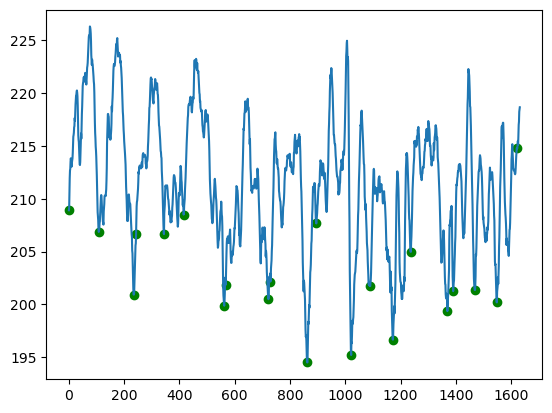

In [23]:
#Plot outcome 
plt.scatter(data.index, data['tb_min'], c='g')
plt.plot(data.index, data['tailbase_y'])
plt.rcParams["figure.figsize"] = (10,30)
plt.show()

In [24]:
def h5_process3(data):
    data["fp_max_mean"] = data["fp_max"].mean() #taking maximum front paw values and averaging to get proxy treadmill belt height.
    data["back_mean"] = data["back_top_y"].mean() #this is averaging back top y position across ALL frames.
    data["mouse_size"] = data["fp_max_mean"]-data["back_mean"] #Not used for this analysis, but kept to have a measure of differences in mouse sizes
    return data

In [25]:
for data in dl:
    data = h5_process3(data)

In [27]:
#Make ratio 0-1 between belt and back.
#Back lowest pixel value = will be our 0 (highest area in visual frame)
#Belt highest pixel value = will be our 1 (lower area in visual frame)
#Line 1: We subtract back mean from belt mean - is the mouse size.  
#Line 2: The back mean will be subtracted from tailbase mean 
#Line 3: The resulting value will be divided by the value of "belt minus back" value to get a value between 0 and 1
#Line 4: takes the mean of the resulting value across frames.
#The resulting value will then be closer to 1 if it is closer to the treadmill belt. This is because a higher y value produced by DLC equals a pixel that is closer to the bottom of the visual frame. For intuition, this is described as reversed in the paper, as if higher y value = pixel in top of visual frame. In the R Studio processing script, the values produced in this script are reversed so a bigger tb_ratio value means the tailbase is kept at a higher level in the visual frame.
def h5_process4(data):
    data['fp_minus_back']= data['fp_max_mean']-data['back_mean'] #corresponds to b-f in equation from paper
    data['tb_minus_back']=data['tailbase_y']-data['back_mean'] #corresponds to y_t - f in equation from paper
    data['tb_ratio'] = data['tb_minus_back']/data['fp_minus_back'] 
    data["tb_ratio_mean"] =data['tb_ratio'].mean() #corresponds to 1/T in equation from paper
    return data


In [28]:
for data in dl:
    data = h5_process4(data)

In [30]:
D = len(dl)
df_combined2 = pd.DataFrame(columns=dl[0].columns,index=np.arange(D))

for dIdx in range(D):
    entry = dl[dIdx].loc[0]
    df_combined2.loc[dIdx] = entry
    #df_combined2 = pd.concat((df_combined2,entry),axis=0)

In [32]:
df_combined2.to_csv('WS_mean_new_method.csv')